In [1]:
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO
import json
import geopandas as gp
import pandas as pd
import os
import pylab as pl
%pylab inline

from scipy.spatial.distance import pdist, squareform

SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

Populating the interactive namespace from numpy and matplotlib


In [2]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode
facilityQuery = 'select count(*), zipcodes from NYCAsthmasDismissals group by zipcodes'
facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities

,count,zipcodes
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375
5,494,10466
6,713,11212
7,167,11229
8,521,11215
9,386,11220


In [3]:
# download zipcode shapefiles
url = 'https://data.cityofnewyork.us/api/file_data/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip'
cmd = 'curl -o ' + os.getenv('PUIDATA') + '/zipcodes.zip ' + url
os.system(cmd)

os.chdir(os.getenv('PUIDATA'))
os.system('unzip zipcodes.zip -d ' + os.getenv('PUIDATA') + '/zipcodes')

# read in
zips = gp.read_file('ZIP_CODE_040114.shp')


In [4]:
# calculate centroids
zips['cents'] = zips.geometry.centroid

In [5]:
# merge to counts
zips.ZIPCODE = zips.ZIPCODE.astype('int')
zips = facilities.merge(zips, left_on = 'zipcodes', right_on = 'ZIPCODE')[['count','zipcodes','cents']]

In [6]:
zips.cents[0].y

247902.4282787614

In [7]:
# counts, x-loc, y-loc
zips['xloc'] = [i.x for i in zips.cents]
zips['yloc'] = [i.y for i in zips.cents]

zips = zips[['xloc','yloc','count']]
zips.head()

,xloc,yloc,count
0,1.028293e+06,247902.428279,1699
1,1.017941e+06,208485.104666,405
2,1.005359e+06,238316.067516,1698
3,1.050361e+06,158235.462432,220
4,1.026858e+06,201880.223482,246


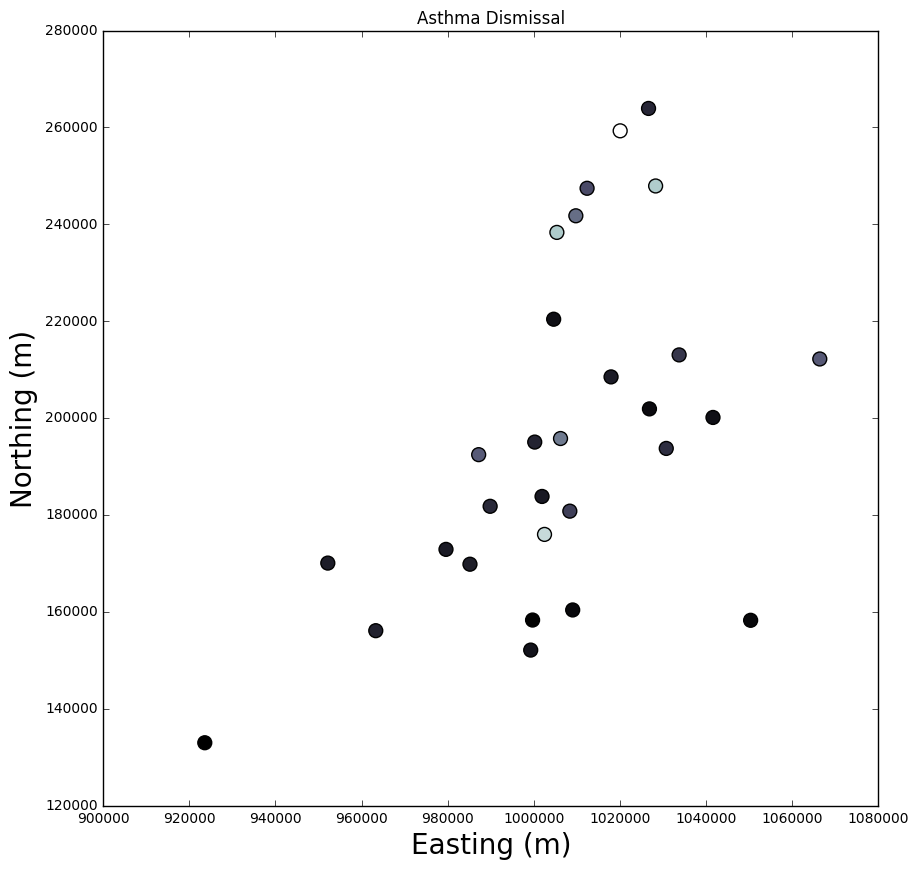

In [8]:
ax = pl.figure(figsize=(10,10), dpi=150).add_subplot(111)
pl.scatter(zips.xloc, zips.yloc, s=100, c = zips['count']/1.0, cmap='bone')
pl.xlabel("Easting (m)", fontsize=20)
pl.ylabel("Northing (m)", fontsize=20)
pl.title('Asthma Dismissal')

### Figure 1: We see spatial autocorrelation in the asthma dismissal data. The dark circles are to the bottom left and get lighter, on average, as we move up and to the right.

In [9]:
def SVh_vctzd( P, h, bw ):
    '''
    Experimental semivariogram for a single lag
    bw max distance
    h lag
    P data
    '''
    pdsv = squareform( pdist( P[:,:2] ) )
    #print pdsv
    N = pdsv.shape[0]
    #print N
    #print np.triu_indices(N)
    Z = np.zeros((N,N))
    Z = Z - P[:,2]
    #print Z
    Z = Z.T + P[:,2]
    #print Z
    Z = Z**2
    #print Z
    Zcd =  Z[(pdsv >= h - bw) * (pdsv <= h + bw) * \
            (~np.identity(N, dtype=bool))]

    #print Zcd
    return np.sum( Zcd ) / ( 2.0 * len( Zcd ) )

def SV( P, hs, bw ):
    '''
    Experimental variogram for a collection of lags
    '''
    sv = list()
    for h in hs:
        #print h
        #sv.append( SVh( P, h, bw ) )
        sv.append( SVh_vctzd ( P, h, bw ) )
    sv = [ [ hs[i], sv[i] ] for i in range( len( hs ) ) if sv[i] > 0 ]
    return np.array( sv ).T


In [15]:
lag = 100
mysv = SV( zips.as_matrix(), np.arange(1, 10000, lag), 500 )
mysv

array([[    5101.        ,     5201.        ,     5301.        ,
            5401.        ,     5501.        ,     5601.        ,
            5701.        ,     5801.        ,     5901.        ,
            6001.        ,     6101.        ,     6201.        ,
            6301.        ,     6401.        ,     6501.        ,
            6601.        ,     6701.        ,     6801.        ,
            6901.        ,     7001.        ,     7101.        ,
            7201.        ,     7301.        ,     7401.        ,
            7501.        ,     7601.        ,     7701.        ,
            7801.        ,     7901.        ,     8001.        ,
            8101.        ,     8201.        ,     8301.        ,
            8401.        ,     8501.        ,     8601.        ,
            8701.        ,     8801.        ,     8901.        ,
            9001.        ,     9101.        ,     9201.        ,
            9301.        ,     9401.        ,     9501.        ,
            9601.        

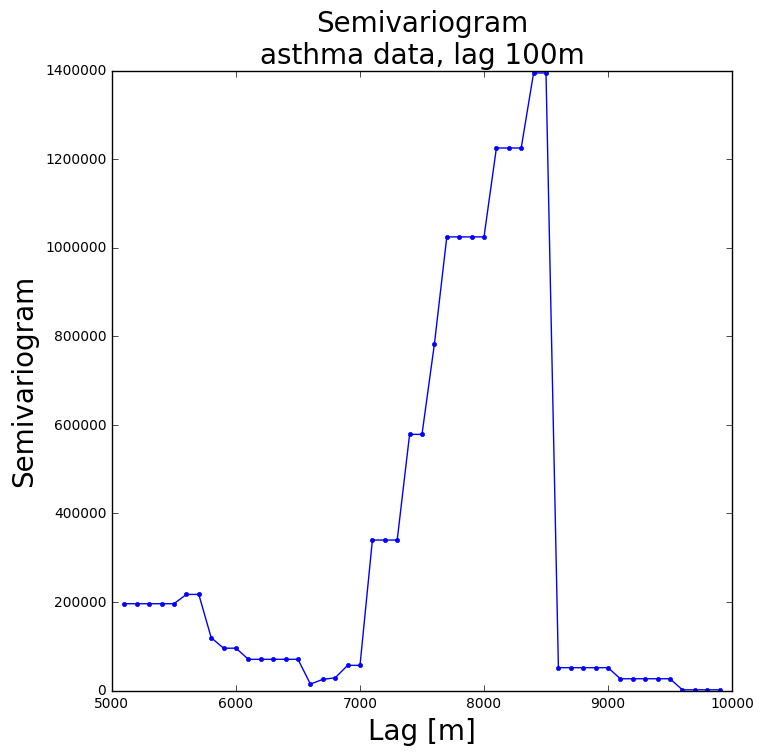

In [11]:
# lags in 500 meter increments from zero to 10,000
hs = np.arange(0, 10500, lag)
#mysv = SV( x, hs, bw )
pl.figure(figsize=(8,8))
plot( mysv[0], mysv[1], '.-' )
pl.xlabel('Lag [m]', fontsize=20)
pl.ylabel('Semivariogram', fontsize=20)
pl.title('Semivariogram\nasthma data, lag %dm'%lag, fontsize=20) 